In [1]:
import csv
from graph_tool import Graph
import pandas as pd
import netpixi
from netpixi.data.gt import *
import seaborn as sns
from graph_tool import centrality
from graph_tool import clustering
import matplotlib.pyplot as plt
sns.set()

### Rede
---

A rede criada é baseada em um dataset de doações de vacinas realizaas durante a pandemia do COVID-19. Desse modo, uma aresta sai de um país que doou a vacina e entra no país que recebeu a doação (rede dirigida).

In [2]:
# Dataset com as doações

donations = pd.read_csv('vacinas_certo.csv')
donations_drop = donations[['Donating Entity','Donated to','Donation Amount']]
donations_drop.head()

,Donating Entity,Donated to,Donation Amount
0,Alrosa Group,Angola,"50,000"
1,Alrosa Group,Zimbabwe,"50,000"
2,Association of Healthcare Providers,India,"100,000,000*"
3,Australia,Unknown,"38,902,000"
4,Australia,Timor-Leste,"30,000"


In [3]:
## Dataset com os PIBs de cada país

pib = pd.read_csv('pib_certo.csv')
pib.head()

,Donating Entity,2020
0,Aruba,NaN
1,Africa Eastern and Southern,9.008290e+11
2,Afghanistan,1.980707e+10
3,Africa Western and Central,7.865850e+11
4,Angola,6.230691e+10


In [4]:
# Alocando uma coluna de PIB para os países que doaram a vacina

df = pd.merge(donations_drop, pib, 
                   on='Donating Entity', 
                   how='left')
df.head()

,Donating Entity,Donated to,Donation Amount,2020
0,Alrosa Group,Angola,"50,000",NaN
1,Alrosa Group,Zimbabwe,"50,000",NaN
2,Association of Healthcare Providers,India,"100,000,000*",NaN
3,Australia,Unknown,"38,902,000",1.330900e+12
4,Australia,Timor-Leste,"30,000",1.330900e+12


In [5]:
# Alocando uma coluna de PIB para os países receptores e arrumando as colunas

df = pd.merge(df, pib, how='left', left_on = 'Donated to', right_on = 'Donating Entity')

df.drop('Donating Entity_y', axis='columns', inplace=True)

df = df.dropna(0,'any') 
df

,Donating Entity_x,Donated to,Donation Amount,2020_x,2020_y
4,Australia,Timor-Leste,"30,000",1.330900e+12,1.821000e+09
7,Australia,Fiji,"1,000,000",1.330900e+12,4.376015e+09
8,Australia,Solomon Islands,"60,000",1.330900e+12,1.551246e+09
9,Australia,Papua New Guinea,"8,000",1.330900e+12,2.359152e+10
13,Azerbaijan,Tajikistan,"40,000",4.260718e+10,8.194150e+09
...,...,...,...,...,...
373,United States,Ukraine,"428,571",2.093660e+13,1.555820e+11
375,United States,West Bank and Gaza,"428,571",2.093660e+13,1.556130e+10
380,United States,Canada,"1,500,000",2.093660e+13,1.644040e+12
381,United States,Mexico,"2,500,000",2.093660e+13,1.076160e+12


In [6]:
# Renomeando as colunas 

df = df.rename(columns = {'Donating Entity_x': 'Donating Entity', '2020_x': 'PIB_doador', '2020_y': 'PIB_receptor'}, 
                     inplace = False)

In [7]:
# Transformando a coluna de doações em float
df['amount'] = df['Donation Amount'].str.replace(',', '').astype(float)
df.drop('Donation Amount', axis='columns', inplace=True)
df = df.rename(columns = {'amount': 'Donation_Amount'}, inplace = False)
df

,Donating Entity,Donated to,PIB_doador,PIB_receptor,Donation_Amount
4,Australia,Timor-Leste,1.330900e+12,1.821000e+09,30000.0
7,Australia,Fiji,1.330900e+12,4.376015e+09,1000000.0
8,Australia,Solomon Islands,1.330900e+12,1.551246e+09,60000.0
9,Australia,Papua New Guinea,1.330900e+12,2.359152e+10,8000.0
13,Azerbaijan,Tajikistan,4.260718e+10,8.194150e+09,40000.0
...,...,...,...,...,...
373,United States,Ukraine,2.093660e+13,1.555820e+11,428571.0
375,United States,West Bank and Gaza,2.093660e+13,1.556130e+10,428571.0
380,United States,Canada,2.093660e+13,1.644040e+12,1500000.0
381,United States,Mexico,2.093660e+13,1.076160e+12,2500000.0


In [8]:
# Criando o grafo da rede

g = Graph(directed=True)

In [9]:
# Criando uma propriedade para os vértices de Países
g.vp['Nome País'] = g.new_vp('object')

lista_paises = []

for i in df['Donating Entity']:
    if i not in lista_paises:
        lista_paises.append(i)
        
for i in df['Donated to']:
    if i not in lista_paises:
        lista_paises.append(i)
    
for i in range(len(lista_paises)):
    g.add_vertex()
    g.vp['Nome País'][i] = lista_paises[i]

In [10]:
for e in g.vertices():
    print(g.vp['Nome País'][e])

print(len(lista_paises))

Australia
Azerbaijan
Barbados
Chile
China
France
Germany
India
Ireland
Israel
Japan
Lithuania
Mexico
Morocco
New Zealand
Poland
Portugal
Romania
Serbia
South Africa
Turkey
United States
Timor-Leste
Fiji
Solomon Islands
Papua New Guinea
Tajikistan
Uzbekistan
Guyana
Ecuador
Malaysia
Thailand
Vietnam
Cambodia
Kiribati
Philippines
Myanmar
Sri Lanka
Pakistan
Nepal
El Salvador
Namibia
North Macedonia
Afghanistan
Chad
Congo, Rep.
Djibouti
Bolivia
Equatorial Guinea
Georgia
Guinea
Iraq
Sierra Leone
Gabon
Togo
Algeria
Angola
Belarus
Dominican Republic
Ethiopia
Lebanon
Maldives
Mauritania
Mongolia
Montenegro
Niger
Sudan
Tunisia
Zimbabwe
Bangladesh
Benin
Botswana
Cameroon
Mauritius
Somalia
Ukraine
Moldova
Cote d'Ivoire
Bhutan
Jamaica
Paraguay
Albania
Belize
Dominica
Eswatini
Ghana
Guatemala
Kenya
Malawi
Mozambique
Nicaragua
Nigeria
Rwanda
Senegal
Seychelles
St. Lucia
Suriname
Uganda
Honduras
West Bank and Gaza
Indonesia
Cyprus
Libya
Lesotho
Liberia
Madagascar
Panama
Peru
Colombia
Costa Rica
Argent

In [11]:
# Criando as arestas e uma propriedade de aresta indicando quantas vacinas foram doadas

from graph_tool import util

g.ep['Número de doações'] = g.new_ep('object')

for pais_doador, pais_receptor, index in zip(df['Donating Entity'], df['Donated to'], df.index):
    str_index_doador = util.find_vertex(g,g.vp['Nome País'],pais_doador) 
    index_doador = int(str(str_index_doador).split(" ")[4].replace("'","")) #pega o índice do doador
    
    str_index_receptor = util.find_vertex(g,g.vp['Nome País'],pais_receptor) 
    index_receptor = int(str(str_index_receptor).split(" ")[4].replace("'","")) #pega o índice do receptor
    
    aresta_existe = 0
    for e in g.edges():
        if g.ep['Número de doações'][e] == None:
            g.ep['Número de doações'][e] = 0

        # Se a aresta já existir, incrementa o número de vacinas doadas
        if e.source() == index_doador and e.target() == index_receptor:
            g.ep['Número de doações'][e] += int(df['Donation_Amount'][index])
            aresta_existe = 1

    # Se a aresta não existe, cria uma nova
    if aresta_existe == 0:
        g.add_edge(index_doador, index_receptor)
        
        e = g.edge(index_doador, index_receptor)
        g.ep['Número de doações'][e] = df['Donation_Amount'][index]


Vamos verificar se funcionou:

In [12]:
for e in g.edges():
    print(g.ep['Número de doações'][e])


30000.0
1000000.0
60000.0
8000.0
40000.0
50000.0
3000.0
20000.0
1500000.0
2500000.0
3500000.0
6903000.0
100000.0
90000.0
2000000.0
3000000.0
2700000.0
5500000.0
3400000.0
300000.0
1650000.0
100000.0
1400000.0
1100000.0
200000.0
100000.0
300000.0
300000.0
100000.0
200000.0
400000.0
40000.0
350000.0
200000.0
100000.0
200000.0
200000.0
200000.0
150000.0
30000.0
100000.0
50000.0
300000.0
50000.0
418000.0
50000.0
300000.0
30000.0
400000.0
250000.0
100000.0
800000.0
600000.0
100000.0
200000.0
200000.0
20000.0
100000.0
200000.0
218400.0
25000.0
25000.0
25000.0
25000.0
200000.0
50000.0
3300000.0
550000.0
200000.0
1100000.0
200000.0
500000.0
50000.0
100000.0
25000.0
30000.0
70000.0
30000.0
20000.0
100000.0
50000.0
200000.0
80000.0
100000.0
50000.0
100000.0
150000.0
100000.0
1700000.0
30000.0
200000.0
25000.0
100000.0
50000.0
25000.0
50000.0
500000.0
25000.0
50000.0
100000.0
35000.0
335500.0
5000.0
5000.0
3000000.0
1000000.0
1000000.0
1000000.0
1000000.0
1050000.0
15000.0
11000.0
100000.0
100800

In [73]:
# Rendereizando o grafo da rede

save_gt(g, 'doacao_vacinas.net.gz')
r = netpixi.render('doacao_vacinas.net.gz');

In [74]:
# "Nomeando" os vértices da rede

r.vertex_set_key('Nome País')

### Hipótese 
---

1) Países com maior economia doam mais vacinas

Mecanismo: Países mais ricos produziram e vacinaram pessoas mais rápido para poder voltar sua economia por possuirem mais recursos e maior organização para a vacinação de sua população. Com isso, sobraram mais vacinas do que esperado e portanto, doaram suas vacinas pois parte de sua economia depende da economia do resto do mundo para exportar seus produtos.

Primeiramente, pode-se verificar parâmetros como a média e o desvio-padrão das variáveis de interesse (que são o PIB e o número de vacinas doadas) para entendê-las mais a fundo.

In [15]:
df['PIB_doador'].describe()

count    2.170000e+02
mean     1.126823e+13
std      7.661085e+12
min      4.365500e+09
25%      2.622980e+12
50%      1.472270e+13
75%      1.472270e+13
max      2.093660e+13
Name: PIB_doador, dtype: float64

Pode-se observar que o desvio-padrão é muito alto, indicando que os países da rede têm uma alta diversidade no aspecto de riquezas, o que é interessante na medida em que isso traz diversidade e logo enriquece a qualidade dos dados. Também é possível perceber esse aspecto quando observa-se os valores mínimo e máximo de PIB: há uma disparidade muito grande o que indica uma diversidade de países.

In [16]:
df['Donation_Amount'].describe()

count    2.170000e+02
mean     6.355716e+05
std      9.699816e+05
min      2.000000e+03
25%      1.000000e+05
50%      2.082600e+05
75%      7.000000e+05
max      5.700000e+06
Name: Donation_Amount, dtype: float64

Características similares podem ser observadas com a variável de quantidade de vacinas doadas por cada país: o desvio-padrão é muito grande, talvez porque existem tanto países que possam doar muitas vacinas como EUA e China, como também alguns que praticamente não o fazem por terem pouca influência.

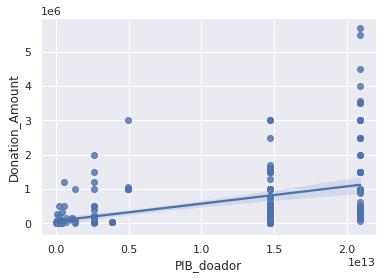

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

sns.regplot(x=df['PIB_doador'], y=df['Donation_Amount'])
plt.show()


Após plotar o gráfico de correlação entre as duas variáveis de interesse, foi notado que os valores ficaram "achatados", sendo necessário aplicar o log para facilitar a visualização:

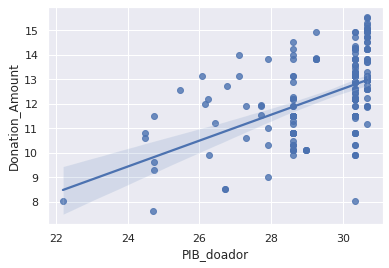

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set()

sns.regplot(x=np.log(df['PIB_doador']), y=np.log(df['Donation_Amount']))
plt.show()


Parece que a relação entre PIB e doações realmente existe, visto que o gráfico apresenta uma inclinação ascendente. No entanto, para confirmar se de fato existe uma relação estatísticamente significativa entre as duas variáveis, é possível criar um modelo de regressão linear e verificar o p-valor obtido:

In [19]:
import numpy as np
import statsmodels.formula.api as smf

model = smf.ols(data=df, formula='np.log(Donation_Amount) ~ PIB_doador')
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     np.log(Donation_Amount)   R-squared:                       0.277
Model:                                 OLS   Adj. R-squared:                  0.274
Method:                      Least Squares   F-statistic:                     82.35
Date:                     Tue, 16 Nov 2021   Prob (F-statistic):           7.40e-17
Time:                             22:15:35   Log-Likelihood:                -371.22
No. Observations:                      217   AIC:                             746.4
Df Residuals:                          215   BIC:                             753.2
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.1155      0.163     68.341      0.000      10.795      11.436
PIB_doador  1.084e-13   1.19e-14      9.075      0.000    8.49e-14    1.32e-13
==============================================================================
Omnibus:                        0.977   Durbin-Watson:                   1.573
Prob(Omnibus):                  0.614   Jarque-Bera (JB):                0.709
Skew:                          -0.121   Prob(JB):                        0.702
Kurtosis:                       3.139   Cond. No.                     2.43e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.43e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

A partir do modelo é possível rejeitar a hipótese nula dado que o P-Valor obtido é menor que 0.1 e, portanto, pode-se afirmar que quanto mais rico um país é, mais doações de vacinas ele realizou. Porém, o R-squared obtido foi de apenas 0.277, indicando que o poder explicativo do modelo é ruim.

## Análise de resíduos

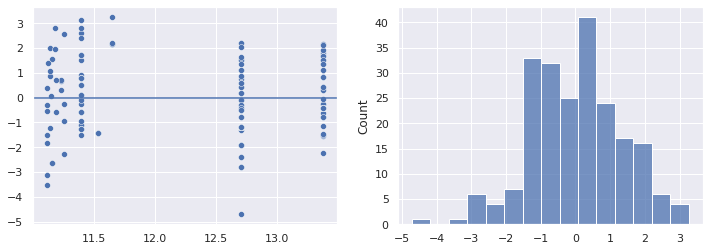

In [20]:
from matplotlib import rcParams

def linear_resplot(result):
    width, height = rcParams['figure.figsize']
    fig, axs = plt.subplots(1, 2, figsize=(2 * width, height))
    ax = sns.scatterplot(x=result.fittedvalues, y=result.resid, ax=axs[0])
    ax.axhline(0)
    sns.histplot(result.resid, ax=axs[1])
    plt.show()

linear_resplot(result)

Como pode-se observar, o histograma dos resíduos que foi obtido se aproxima de uma distribuição normal, indicando que houve um erro "pequeno" do modelo de regressão linear. Ele não é exatamente uma distribuição normal, porém isso é aceitável dado o número de amostras do dataset que é pequeno.

## Análise de exceções

Ao observar o dataframe de maneira a mostrar quais países têm o maior PIB de maneira decrescente, foi possível perceber que a França é um exemplo de país em que o mecanismo não está ativo. Verificando a quantidade de doações realizadas por cada país, percebe-se que a França doou apenas uma vez:

In [21]:
df['Donating Entity'].value_counts()

China            84
United States    49
India            46
Japan             6
Germany           4
Australia         4
Mexico            3
Lithuania         3
Israel            2
Azerbaijan        2
Poland            2
Turkey            2
France            1
Chile             1
Ireland           1
Barbados          1
Morocco           1
New Zealand       1
Portugal          1
Romania           1
Serbia            1
South Africa      1
Name: Donating Entity, dtype: int64

Agora, para verificar que a França é realmente um país com PIB alto, foi construída uma tabela que está organizada de maneira descendente de acordo com o PIB de cada país, e com isso, é possível observar que a França é um país com alta riqueza, uma vez que é o quinto país mais rico do dataframe.

In [22]:
df.drop_duplicates(subset=['Donating Entity'], keep='first').sort_values(by=['PIB_doador'], ascending = False)

,Donating Entity,Donated to,PIB_doador,PIB_receptor,Donation_Amount
315,United States,Nigeria,2.093660e+13,4.322940e+11,3577860.0
30,China,Malaysia,1.472270e+13,3.366640e+11,1000000.0
231,Japan,Bangladesh,4.975420e+12,3.242390e+11,3000000.0
152,Germany,Namibia,3.846410e+12,1.069993e+10,25000.0
149,France,Sudan,2.630320e+12,2.611083e+10,218400.0
163,India,Maldives,2.622980e+12,4.030203e+09,100000.0
4,Australia,Timor-Leste,1.330900e+12,1.821000e+09,30000.0
249,Mexico,El Salvador,1.076160e+12,2.463872e+10,100800.0
302,Turkey,Cyprus,7.201010e+11,2.380434e+10,40000.0
269,Poland,Vietnam,5.941650e+11,2.711580e+11,500000.0


Por isso, faz-se necessária a formulação de uma nova hipótese para o caso em que o mecanismo não está ativo como o da França. 

Nova Hipótese: Países com PIB alto em que a gestão do COVID foi ruim doaram poucas vacinas.

Mecanismo: Países com PIB alto, apesar de terem mais recursos, nem sempre doarão mais vacinas. Isso se justifica porque pode faltar organização na campanha de vacinação nacional  por uma gestão por parte do representante do país que tenha sido ruim, por exemplo. Esse é o caso da França, em que Macron recebeu críticas da maneira como lidou com a pandemia e os casos voltaram a subir depois de  alguns meses, impossibilitando a doação de vacinas a outros países.

---

In [23]:
import numpy as np
import statsmodels.formula.api as smf

model = smf.ols(data=df, formula=' PIB_doador ~ np.log(Donation_Amount) ')
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             PIB_doador   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                     82.35
Date:                Tue, 16 Nov 2021   Prob (F-statistic):           7.40e-17
Time:                        22:15:36   Log-Likelihood:                -6710.0
No. Observations:                 217   AIC:                         1.342e+04
Df Residuals:                     215   BIC:                         1.343e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept               -2.025e+13    3.5e+12     -5.784      0.000   -2.72e+13   -1.33e+13
np.log(Donation_Amount)  2.555e+12   2.82e+11      9.075      0.000       2e+12    3.11e+12
==============================================================================
Omnibus:                       19.916   Durbin-Watson:                   0.450
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                9.281
Skew:                          -0.297   Prob(JB):                      0.00965
Kurtosis:                       2.180   Cond. No.                         98.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

____
## Hipótese com eigenvector

1) Países com menor riqueza têm maior status.

Mecanismo: 

Vamos criar o eigenvector de cada país e adicionar a uma lista.

In [45]:
from graph_tool import centrality

ec = centrality.pagerank(g, damping=0.85, pers=None, weight=None, prop=None, epsilon=1e-06, max_iter=None, ret_iter=False)

lista_ec = []

for v in ec:
    lista_ec.append(v)

Agora, vamos adicionar essa lista ao grafo, sendo que essa será uma propriedade de cada país. 

In [57]:
g.vp['centralidade eigenvector'] = ec

Também vamos criar uma nova coluna que seja o eigenvector de cada país chamada Status.

In [69]:
atual = 0
novo = 0
i = -1

lista = []
for atual in df['Donating Entity']:
    if atual != novo:
        novo = atual
        i+=1
    lista.append(lista_ec[i])

    
df['Status'] = lista      
df

,Donating Entity,Donated to,PIB_doador,PIB_receptor,Donation_Amount,Status
4,Australia,Timor-Leste,1.330900e+12,1.821000e+09,30000.0,0.007418
7,Australia,Fiji,1.330900e+12,4.376015e+09,1000000.0,0.007418
8,Australia,Solomon Islands,1.330900e+12,1.551246e+09,60000.0,0.007418
9,Australia,Papua New Guinea,1.330900e+12,2.359152e+10,8000.0,0.007418
13,Azerbaijan,Tajikistan,4.260718e+10,8.194150e+09,40000.0,0.007541
...,...,...,...,...,...,...
373,United States,Ukraine,2.093660e+13,1.555820e+11,428571.0,0.007418
375,United States,West Bank and Gaza,2.093660e+13,1.556130e+10,428571.0,0.007418
380,United States,Canada,2.093660e+13,1.644040e+12,1500000.0,0.007418
381,United States,Mexico,2.093660e+13,1.076160e+12,2500000.0,0.007418


Ao plotar o gráfico de interesse, percebemos inicialmente que temos uma relação negativa entre eles, indicando que talvez nossa hipótese formulada seja verdade. 

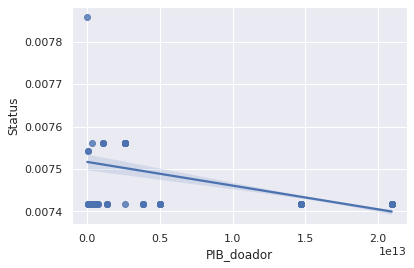

In [64]:
sns.set()

sns.regplot(x=df['PIB_doador'], y=df['Status'])
plt.show()

Mesmo assim, para realmente obter uma conclusão com relação estatísticamente significativa, vamos analisar usando um modelo de regressão linear. 

In [62]:
import numpy as np
import statsmodels.formula.api as smf

model = smf.ols(data=df, formula='Status ~ PIB_doador')
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Status   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     147.8
Date:                Tue, 16 Nov 2021   Prob (F-statistic):           3.17e-26
Time:                        22:31:25   Log-Likelihood:                 1835.2
No. Observations:                 217   AIC:                            -3666.
Df Residuals:                     215   BIC:                            -3660.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0075   6.24e-06   1203.816      0.000       0.008       0.008
PIB_doador -5.575e-18   4.59e-19    -12.157      0.000   -6.48e-18   -4.67e-18
==============================================================================
Omnibus:                       67.954   Durbin-Watson:                   0.802
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              573.848
Skew:                           0.924   Prob(JB):                    2.46e-125
Kurtosis:                      10.749   Cond. No.                     2.43e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.43e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Ao observar o p-valor, percebe-se que eles têm p-valor abaixo de 10%, indicando que a variável explicativa `PIB_doador` é significativa para explicar o `status`. Mesmo assim, o R2 é bem baixo, o que diz que o poder explicativo do modelo é ruim.

## Análise de resíduos

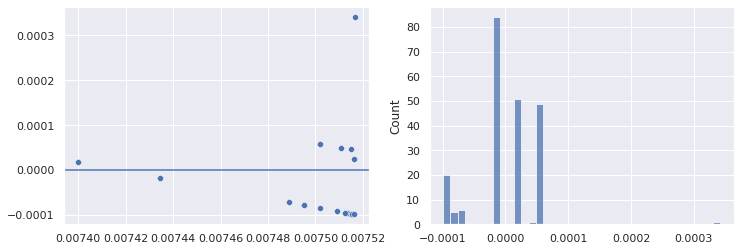

In [67]:
def linear_resplot(result):
    width, height = rcParams['figure.figsize']
    fig, axs = plt.subplots(1, 2, figsize=(2 * width, height))
    ax = sns.scatterplot(x=result.fittedvalues, y=result.resid, ax=axs[0])
    ax.axhline(0)
    sns.histplot(result.resid, ax=axs[1])
    plt.show()

linear_resplot(result)

---------------

In [28]:
cc = centrality.closeness(g)

for v in cc:
    print(v)

1.0
1.0
1.0
1.0
0.9811320754716981
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.75
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


In [29]:
dc = degree_gt(g)

for v in dc:
    print(v)

0.034782608695652174
0.02608695652173913
0.034782608695652174
0.008695652173913044
0.4434782608695652
0.008695652173913044
0.034782608695652174
0.33043478260869563
0.008695652173913044
0.017391304347826087
0.05217391304347826
0.02608695652173913
0.034782608695652174
0.008695652173913044
0.008695652173913044
0.017391304347826087
0.008695652173913044
0.008695652173913044
0.008695652173913044
0.017391304347826087
0.017391304347826087
0.3826086956521739
0.017391304347826087
0.034782608695652174
0.008695652173913044
0.008695652173913044
0.02608695652173913
0.008695652173913044
0.034782608695652174
0.02608695652173913
0.02608695652173913
0.02608695652173913
0.034782608695652174
0.008695652173913044
0.008695652173913044
0.017391304347826087
0.017391304347826087
0.017391304347826087
0.017391304347826087
0.017391304347826087
0.02608695652173913
0.02608695652173913
0.008695652173913044
0.017391304347826087
0.008695652173913044
0.008695652173913044
0.008695652173913044
0.008695652173913044
0.0086